## 线性回归
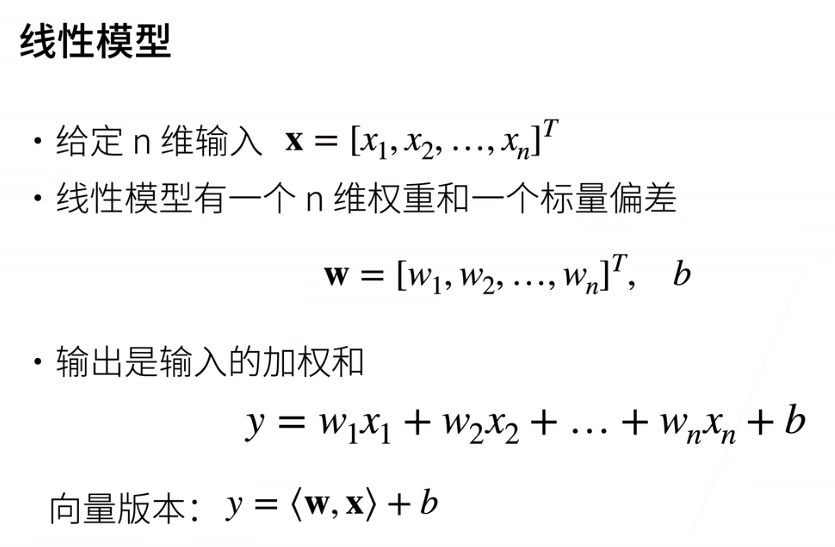

线性模型可以看作单层神经网络  

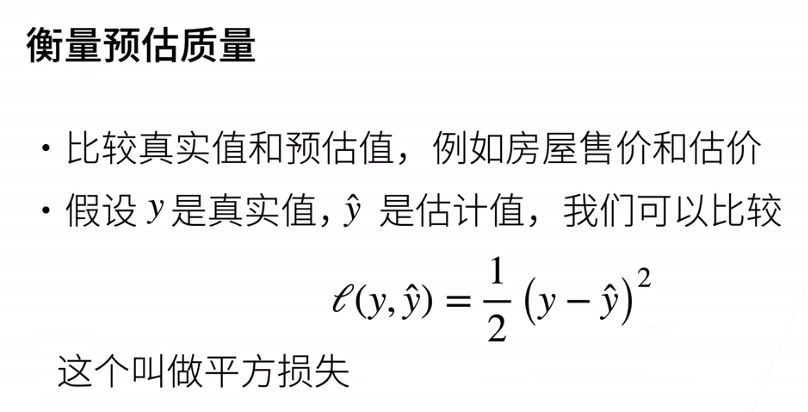

1/2--方便求导

基于数据学习参数（权重和偏差）  
收集一些数据点训练模型--决定参数值  
训练数据，通常越多越好  
n个样本-训练损失-最小化损失来学习参数   
显示解  

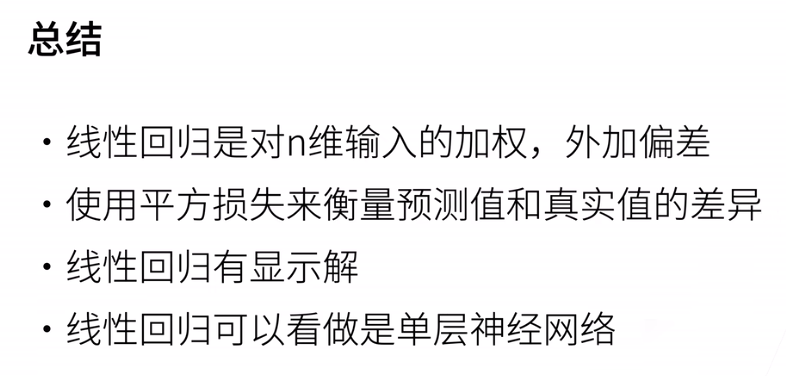

## 基础优化算法
### 梯度下降  
当模型没有显示解，挑选一个参数的随机初始值w0  
接下来不断更新w0，使其接近最优解

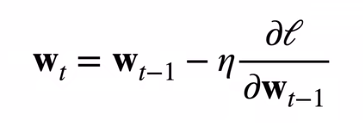

梯度：使函数值增加最快的方向  
学习率：每次沿方向走多远，超参数，不能太小也不能太大   

### 小批量随机梯度下降
梯度下降中每次计算梯度，要对整个损失函数求导，损失函数是对所有样本的平均损失，需数分钟至数小时，计算代价太大  
可以随机采样b个样本来近似损失，b越大，近似越准确  
b：批量大小，超参数，不能太小（不合适并行）也不能太大（内存）   

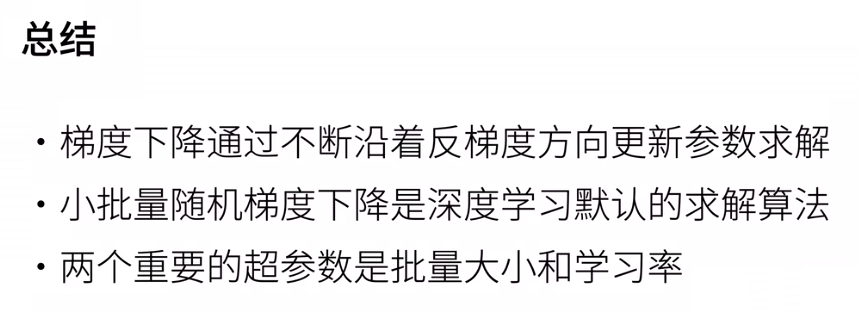

## 线性回归的从零开始实现

In [ ]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l


# 根据带有噪声的线性模型构造一个人造数据集。
# 使用线性模型参数 w = [2, -3.4]T, b = 4.2 和噪声项生成数据集及其标签
def synthetic_data(w, b, num_examples):
    # 生成 y = Xw + b + 噪声
    X = torch.normal(0, 1, (num_examples, len(w)))  # 均值为0，方差为1
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [ ]:
# features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标量）
print('feature:', features[0], '\nlabel:', labels[0])

d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),   # 在一些pytorch版本中，要先detach，从梯度计算图中拿出来，不要算梯度，才能numpy
                labels.detach().numpy(), 1)

In [ ]:
# 定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量
# 实际情况中，数据放在硬盘上，每次随机抓批量大小数据，不需要把整个数据load进内存
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))  # range：0 ~ n-1
    # 随机读取样本，没有特定顺序
    random.shuffle(indices)  # 打乱下标
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices], labels[batch_indices]
        # yield 不断调用函数，不断返回，直到全部完成

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

In [ ]:
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 线性回归模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b

# 损失函数
def squared_loss(y_hat, y):
    # 均方损失
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

# 优化算法
def sgd(params, lr, batch_size):
    # 小批量随机梯度下降
    with torch.no_grad():  # 不需要计算梯度
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()  # 梯度设置为0

In [ ]:
# 训练过程
lr = 0.03   # 更换超参数，w和b要重新随机初始化，不会有上一次的梯度结果
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # l的形状是(batch_size, 1)，不是标量。l中的所有元素被加到一起
        # 并以此计算[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数  可能最后一个批量大小不是batch_size 
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


In [ ]:
# 比较真实参数和通过训练学到的参数来评估训练的成功程度
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

## 线性回归的简洁实现
通过使用深度学习框架简洁地实现线性回归模型

In [1]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [ ]:
# 调用框架中现有的API来读取数据
def load_array(data_arrays, batch_size, is_train=True):
    # 构造一个pytorch数据迭代器
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))  # 转成python的iter，通过next函数得到X和y

In [ ]:
# 使用框架的预定义好的层
from torch import nn
# nn是神经网络的缩写

net = nn.Sequential(nn.Linear(2, 1))  # 指定输入维度，输出维度
# Sequential，可理解为list of layers

# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)  # 第0层，normal_ 正态分布
net[0].bias.data.fill_(0)

# 计算均方误差，也称平方范数L2
loss = nn.MSELoss()

# 实例化SGD实例
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [ ]:
# 训练过程
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()  # 优化器梯度清零，若不清零，会做累加
        l.backward()  # pytorch已经做了sum
        trainer.step()  # 更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

损失可以不求平均  
损失除以n，梯度也除以n--不管批量多大，梯度的值都差不多（调学习率好调）  
损失不除以n，要想结果相同，学习率除以n也可  

最小化损失，并不关心损失值是多少

batch_size越小，收敛越好  
随机梯度下降理论上来说，给模型带来噪音  
batch_size越小，噪音越多，与真实方向可能差很远  
但噪音对神经网络来说是个好事，泛化性  

## Softmax回归
其实是分类问题  

回归：估计一个连续值  
分类：预测一个离散类别

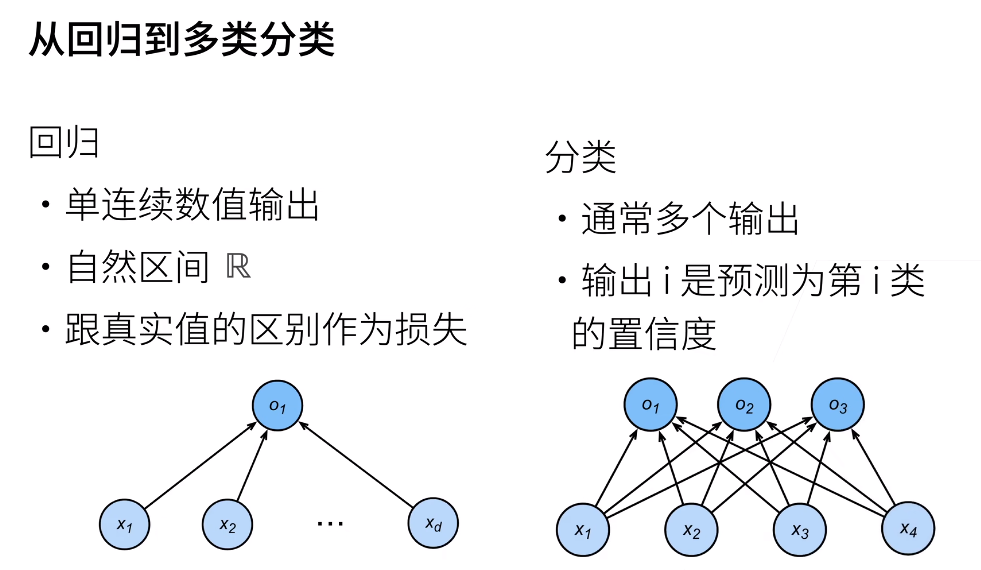

均方损失  
对类别进行一位有效编码  
使用均方损失训练  
最大值为预测  
无校验比例：需要更置信的识别正确类（大余量）-- oy-oi大于某个阈值  
校验比例：输出匹配概率

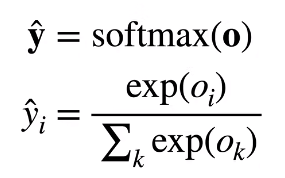

y_hat每个元素非负，和为1  
指数可将任何值变成非负  
概率y和y_hat的区别作为损失

交叉熵常用来衡量两个概率的区别

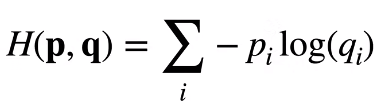

损失--只关心正确类

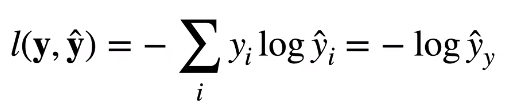

梯度是真实概率和预测概率的区别

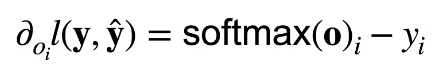

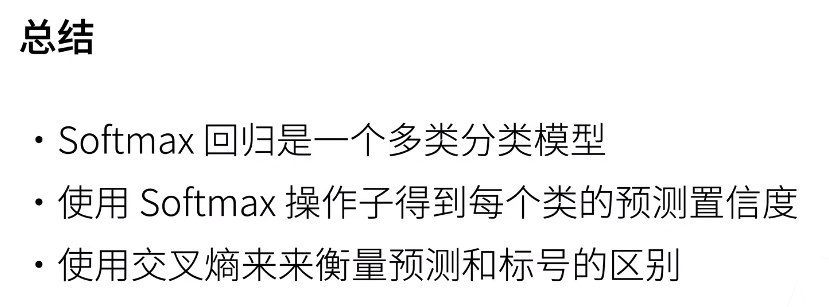

## 损失函数
损失函数用来衡量预测值和真实值之间的区别  
### 均方损失 L2 Loss
![L2 Loss.png](<attachment:L2 Loss.png>)

梯度是一次函数，穿过原点  
梯度下降时，负梯度方向更新参数--导数决定如何更新参数  
当y'离y距离较远时，梯度较大，参数更新较多；y'靠近y，梯度靠近原点，参数更新幅度小--不是特别好的事情

### 绝对值损失函数 L1 Loss
![L1 Loss.png](<attachment:L1 Loss.png>)

零点处不可导  
y'与y不管隔多远，梯度永远是常数，权重更新相同，稳定性上有好处   
零点处剧烈变化，不平滑性导致y'离y比较近时不稳定  

### Huber's Robust Loss
结合上述的好处  
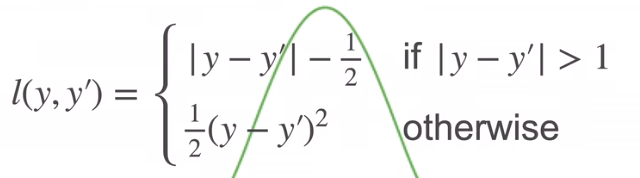

y'与y距离较远时，梯度相同，均匀变化  
y'与y距离较近时，梯度绝对值变小，保证优化较平滑  
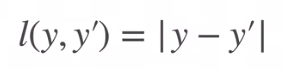
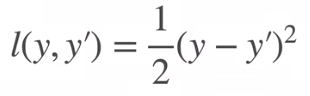

## 图像分类数据集
MNIST数据集是图像分类中广泛使用的数据集之一，但作为基准数据集过于简单。  
我们将使用类似但更复杂的Fashion-MNIST数据集  

In [ ]:
%matplotlib inline
import torch
import torchvision  # pytorch对于计算机视觉模型实现的库
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l


d2l.use_svg_display()  # 用svg显示图片

In [ ]:
# 通过框架中的内置函数将Fashion-MNIST数据集下载并读取到内存中
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，并除以255使得所有像素的数值均在0到1之间
trans = transforms.ToTensor()  # 图片转成pytorch的tensor
mnist_train =  torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)  # download=True 默认从网上下载。也可以事先下载好
# 测试集，验证模型的好坏，不参与训练
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

len(mnist_train), len(mnist_train)
mnist_train[0][0].shape  # 第0个例子 图片
# 黑白图片 一个channel

In [ ]:
# 两个可视化数据集的函数
def get_fashion_mnist_labels(labels):
    '''返回Fashion-MNIST数据集的文本标签'''                                     ############3
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'sh', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    '''plot a list of images'''
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
            ##################################


In [ ]:
# 几个样本的图像及其相应的标签
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))        ############
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))# 显示的时候，显示2行，每行9张图片

In [ ]:
# 读取一小批量数据
batch_size = 256

def get_dataloader_workers():  # 每次读取数据不容易，需要多个进程进行数据读取、操作、预读取
    '''使用4个进程来读取的数据'''
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'  # 扫一遍数据所需时间。读取时间至少要比训练快


In [ ]:
def load_data_fashion_mnist(batch_size, resize=None):
    '''下载Fashion-MNIST数据集，将其加载到内存中'''
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()))

## softmax回归的从零开始实现

In [ ]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [ ]:
# 展平每个图像，将其视为长度为784的向量(会损失空间信息)
# 数据集有10个类别，因此网络输出维度为10
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [ ]:
# 给定一个矩阵X，我们可以对所有元素求和
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)  # 把shape中的第x个元素变成1

In [ ]:
# 实现softmax
def softmax(X):  # X是一个矩阵，对每一行做softmax
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)  # 对每一行进行求和
    return X_exp / partition  # 这里应用了广播机制

# 验证
# 我们将每个元素变成非负数，每行总和为1
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)


In [ ]:
# 实现softmax回归模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)  # 批量大小x输入维数

In [ ]:
# 创建一个数据y_hat，其中包含2个样本在3个类别的预测概率，使用y作为y_hat中概率的索引
# 在预测值里面根据真实标号将对应的预测值拿出来
y = torch.tensor([0, 2])  # 真实标号
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])  # 预测值
y_hat[[0, 1], y]  # 对第0号样本拿出y[0]对应的元素

In [ ]:
# 实现交叉熵损失函数
def cross_entropy(y_hat, y):    
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

# 将预测类别与真实y元素进行比较
def accuracy(y_hat, y):
    # 计算预测正确的数量
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)  # 每行中最大值元素的下标
    cmp = y_hat.type(y.dtype) == y  # 把y_hat转成y的数据类型 cmp：bool tensor
    return float(cmp.type(y.dtype).sum())  # 预测正确的样本数

accuracy(y_hat, y) / len(y)  # 预测正确的概率

In [ ]:
# 可以评估在任意模型net的准确率
def evaluate_accuracy(net, data_iter):
    # 计算在指定数据集上模型的精度
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式，不计算梯度
    metric = Accumulator(2) # 累加器，正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


# Accumulator实例中创建了2个变量，用于分别存储正确预测的数量和预测的总数量
class Accumulator:
    # 在n个变量上累加
    def __init__(self, n):
        self.data = [0.0]*n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0]*len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
evaluate_accuracy(net, test_iter)

In [ ]:
# 训练
def train_epoch_ch3(net, train_iter, loss, updater):
    '''数据迭代一次'''
    if isinstance(net, torch.nn.Module):
        net.train()  # 要计算梯度
    metric = Accumulator(3)  # 损失累加，分类正确样本数，样本总数
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()  # 梯度设为0
            l.backward()  # 计算梯度
            updater.step()  # 参数自更新
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            l.sum().backward()  # 向量求和算梯度
            updater(X.shape[0])  # 根据批量大小
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [ ]:
# 在动画中绘制数据的实用程序类
# 实时看到训练的变化
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1, figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplot(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
# 训练函数
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc, ))
    train_loss, train_acc = train_metrics
    # assert train_loss < 0.5, train_loss
    # assert train_acc <= 1 and train_acc > 0.7, train_acc
    # assert test_acc <= 1 and test_acc > 0.7, test_acc

In [ ]:
# 小批量随机梯度下降来优化模型的损失函数
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [ ]:
# 训练模型
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [ ]:
# 对图像进行分类预测
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:  # 取一部分
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])


predict_ch3(net, test_iter)

## softmax回归的简洁实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [ ]:
# 输出层是一个全连接层
# pytorch不会隐式地调整输入的形状
# 因此，定义展平层（flatten）在线性层前调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))  # flatten：把任何维度的tensor变成2D的tensor，第0维保留，其余维展成向量

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)  # 将init_weights函数apply到net上，每一层都跑一下函数

In [ ]:
# 在交叉熵损失函数中传递未归一化的预测，并同时计算softmax及其对数
loss = nn.CrossEntropyLoss()

# 使用学习率为0.1的小批量随机梯度下降作为优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [ ]:
# 训练模型
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

softmax：一位有效，很难用指数逼近1  
softlabel：正确0.9，其余0.1/n    图片分类常用

逻辑回归可看作两类的softmax回归，负例预测等于（1-正例预测）

只关心两个分布的距离，损失函数会选择算起来相对简单一点的

每个类有没有足够多的样本

最小化损失=最大化似然函数

统计学习，里面很多可解释


## 感知机

## 多层感知机

## 多层感知机的从零开始实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [ ]:
# 实现一个具有单隐藏层的多层感知机，包含256个隐藏单元
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True))
b1 = nn.parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True))
b2 = nn.parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [ ]:
# ReLU激活函数
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

# 模型
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X @ W1 + b1)
    return (H @ W2 + b2)

loss = nn.CrossEntropyLoss()

In [ ]:
# 训练过程
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)